# Sentiment Analysis, Key Phrase Extraction & Word Cloud for Banana Republic

In [1]:
# Installing & Importing Packages

!pip install nltk
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Getting stopwords and punctuations to remove from reviews

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string
stopwords_list = stopwords.words('english') + list(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Getting the Scraped Reviews into a Dataframe

import pandas as pd
train_reviews = pd.read_csv("banana_review_data.csv")
train_reviews.head()

,product_id,Review
0,505167032,Best khakis on the market. Great quality cotto...
1,500726002,"Excellent quality and comfort, a little baggie..."
2,505165052,Error occurred
3,505164012,Made with attention to details. Good purchase.
4,505161032,"My go to office pants. Fit well, wash well, we..."


In [7]:
# Installing Azure Package

!pip install azure-ai-textanalytics

In [8]:
# Authenticating Connection with Azure

import azure

#key = '' #"<paste-your-text-analytics-key-here>"
#endpoint = '' #"<paste-your-text-analytics-endpoint-here>"

key = "6fa304d7949d42d3b53b029bcdef8fba"
endpoint = 'https://sgaddi.cognitiveservices.azure.com/' #"<paste-your-text-analytics-endpoint-here>"

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential


# Create a function to instantiate the TextAnalyticsClient object 
# with your key AND endpoint created above. 
# Then create a new client.

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [11]:
# Create a new function called sentiment_analysis_example() that takes the client as an argument, 
# then calls the analyze_sentiment() function. 
# The returned response object will contain the sentiment score

def sentiment_analysis_example(client, review):
    
    documents = [review]
    response = client.analyze_sentiment(documents=documents)[0]
    print(response)
    
    
    sentiments = []
    
    for idx, sentence in enumerate(response.sentences):
        sentiments.append(sentence['sentiment'])
        
 # We can also assign a score of positive to each sentence with a positive sentiment score of greater than 0.5 
    # and a negative sentiment to those with a score of less than or equal to 0.5
    
#     for idx, sentence in enumerate(response.sentences):
#         if(sentence.confidence_scores.positive > 0.5):
#             sentiments.append('positive')
#         else:
#             sentiments.append('negative')
            
    return sentiments

In [15]:
word_list = word_tokenize(train_reviews.Review.iloc[0])
word_dictionary = dict([(word, True) for word in word_list])
sample_tuple = (word_dictionary,'positive')

In [17]:
# Running Sentiment Analysis on the Reviews using Azure

import requests
import time

azure_sentiments = []

review_number = 0
time_counter = time.time()

requests_per_second_limit = 100
requests_per_minute_limit = 300

for review in list(train_reviews.Review[0:100]):
    review_number+=1
    print(review_number)
    sentiment = sentiment_analysis_example(client, review)
    end_time = time.time()
    
    requests_in_this_second = review_number % requests_per_second_limit
    requests_in_this_minute = review_number % requests_per_minute_limit
    
    if requests_in_this_second == 0:
        time_taken_for_batch = end_time - time_counter
        if time_taken_for_batch < 1:
            time.sleep(1 - time_taken_for_batch)
        time_counter = time.time()
    
    if requests_in_this_minute == 0:
        time_taken_for_minute = end_time - time_counter
        if time_taken_for_minute < 60:
            time.sleep(60 - time_taken_for_minute)
        time_counter = time.time()  
    
    

    azure_sentiments.append(sentiment)

1
{'id': '0', 'sentiment': 'positive', 'warnings': [], 'statistics': None, 'confidence_scores': SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), 'sentences': [SentenceSentiment(text=Best khakis on the market. , sentiment=positive, confidence_scores=SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), length=27, offset=0, mined_opinions=[]), SentenceSentiment(text=Great quality cotton. , sentiment=positive, confidence_scores=SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), length=22, offset=27, mined_opinions=[]), SentenceSentiment(text=True non iron treatment. , sentiment=neutral, confidence_scores=SentimentConfidenceScores(positive=0.22, neutral=0.74, negative=0.04), length=25, offset=49, mined_opinions=[]), SentenceSentiment(text=Fit well, and comfortable move in. , sentiment=positive, confidence_scores=SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), length=35, offset=74, mined_opinions=[]), SentenceSentiment(te

In [20]:
# Using Azure for Key Phrase Extraction from the Reviews

import os
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient
import time

cloud_words = []
text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(key))

for i in range(0, 86, 10):
    chunk = train_reviews.iloc[i:i+10]
    articles = [x for x in chunk.Review]

    result = text_analytics_client.extract_key_phrases(articles)
    for idx, doc in enumerate(result):
        if not doc.is_error:
            print("Key phrases in article #{}: {}".format(
                i + 1,
                ", ".join(doc.key_phrases)
            ))
            cloud_words.append(doc.key_phrases)
    # Sleep for 8 seconds
    time.sleep(8)


cloud_words

Key phrases in article #1: True non iron treatment, Great quality cotton, Best khakis, market, year, wear, work, town
Key phrases in article #1: Excellent quality, comfort
Key phrases in article #1: Error
Key phrases in article #1: Good purchase, attention, details
Key phrases in article #1: office pants
Key phrases in article #1: Amazing quality
Key phrases in article #1: Sizing
Key phrases in article #1: dark brown corduroy, zero waist gap, ankle bone, high rise, slight taper, new favorite, coal, green, 4 tall, pants, length, hourglass, straight, barrel, bottom
Key phrases in article #1: Slim Traveler Jean, BR jeans, Highest recommendation, little stretch, comfort, years, day
Key phrases in article #1: great fit, full day, wear, work, color, comfort, pants
Key phrases in article #11: small waist, wrinkles
Key phrases in article #11: pants, belt
Key phrases in article #11: evolving traveler pants, perfect year-round pants, best colors, textures, fabric, wash, wear, occasion
Key phrase

[['True non iron treatment',
  'Great quality cotton',
  'Best khakis',
  'market',
  'year',
  'wear',
  'work',
  'town'],
 ['Excellent quality', 'comfort'],
 ['Error'],
 ['Good purchase', 'attention', 'details'],
 ['office pants'],
 ['Amazing quality'],
 ['Sizing'],
 ['dark brown corduroy',
  'zero waist gap',
  'ankle bone',
  'high rise',
  'slight taper',
  'new favorite',
  'coal',
  'green',
  '4 tall',
  'pants',
  'length',
  'hourglass',
  'straight',
  'barrel',
  'bottom'],
 ['Slim Traveler Jean',
  'BR jeans',
  'Highest recommendation',
  'little stretch',
  'comfort',
  'years',
  'day'],
 ['great fit', 'full day', 'wear', 'work', 'color', 'comfort', 'pants'],
 ['small waist', 'wrinkles'],
 ['pants', 'belt'],
 ['evolving traveler pants',
  'perfect year-round pants',
  'best colors',
  'textures',
  'fabric',
  'wash',
  'wear',
  'occasion'],
 ['review'],
 ['review'],
 ['Great fabric'],
 ['straight leg opening',
  'modern pants',
  'Classic',
  'openings',
  'something

In [22]:
# Prepping the Extracted Key Phrases for a Word Cloud

cloud_input = []
for element in cloud_words:
        if type(element) is list:
            # Check if type is list than iterate through the sublist
            for item in element:
                cloud_input.append(item)
        else:
            cloud_input.append(element)

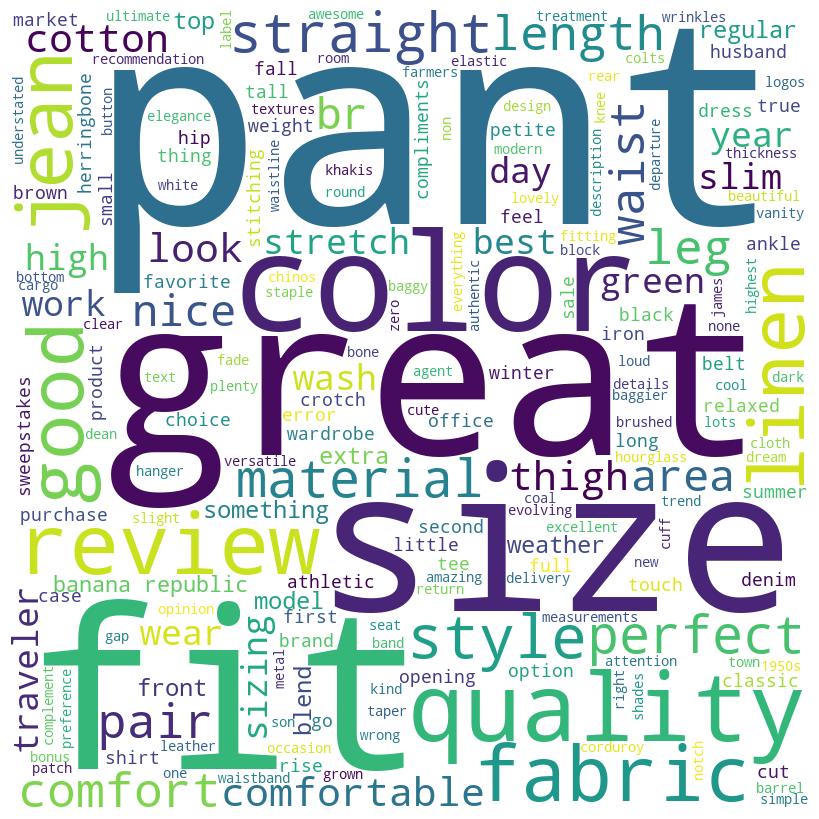

In [24]:
# Creating a Word Cloud using the Extracted Key Phrases

import matplotlib.pyplot as plt  # Use pyplot for plotting
import pandas as pd  # Ensure pandas is correctly imported
from wordcloud import WordCloud, STOPWORDS  # WordCloud and STOPWORDS for generating word clouds


# Initialize an empty string to store all words
comment_words = ''

# Loop through each entry in the cloud_input list
for i in range(len(cloud_input)):
    cloud_input[i] = cloud_input[i].lower()  # Convert to lowercase
    comment_words += " ".join(cloud_input[i].split()) + " "  # Concatenate words with spaces

# Define stopwords
stopwords = set(STOPWORDS)

# Generate word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Sentiment Analysis, Key Phrase Extraction & Word Cloud for Old Navy

In [26]:
train_reviews_on = pd.read_csv("oldnavy_review_data.csv")
train_reviews_on.head()

,product_id,Review
0,544320032,Comfy and great fit!
1,512267012,Nice fitting shirt. I ordered the tall because...
2,421441032,"Comfortable a little baggy, soft."
3,544338002,"The color is not only unique, The texture is v..."
4,510947022,Love it a ton!


In [28]:
# Running Sentiment Analysis on the Reviews using Azure

import requests
import time

azure_sentiments = []

review_number = 0
time_counter = time.time()

requests_per_second_limit = 100
requests_per_minute_limit = 300

for review in list(train_reviews_on.Review[0:200]):
    review_number+=1
    print(review_number)
    sentiment = sentiment_analysis_example(client, review)
    end_time = time.time()
    
    requests_in_this_second = review_number % requests_per_second_limit
    requests_in_this_minute = review_number % requests_per_minute_limit
    
    if requests_in_this_second == 0:
        time_taken_for_batch = end_time - time_counter
        if time_taken_for_batch < 1:
            time.sleep(1 - time_taken_for_batch)
        time_counter = time.time()
    
    if requests_in_this_minute == 0:
        time_taken_for_minute = end_time - time_counter
        if time_taken_for_minute < 60:
            time.sleep(60 - time_taken_for_minute)
        time_counter = time.time()  
    
    

    azure_sentiments.append(sentiment)

1
{'id': '0', 'sentiment': 'positive', 'warnings': [], 'statistics': None, 'confidence_scores': SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), 'sentences': [SentenceSentiment(text=Comfy and great fit!, sentiment=positive, confidence_scores=SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), length=20, offset=0, mined_opinions=[])], 'is_error': False, 'kind': 'SentimentAnalysis'}
2
{'id': '0', 'sentiment': 'positive', 'warnings': [], 'statistics': None, 'confidence_scores': SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), 'sentences': [SentenceSentiment(text=Nice fitting shirt. , sentiment=positive, confidence_scores=SentimentConfidenceScores(positive=1.0, neutral=0.0, negative=0.0), length=20, offset=0, mined_opinions=[]), SentenceSentiment(text=I ordered the tall because I like a longer style and the fabric is not too thick, so will be perfect for layering., sentiment=positive, confidence_scores=SentimentConfidenceScores(positive

In [48]:
# Using Azure for Key Phrase Extraction from the Reviews

import os
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient
import time

cloud_words_on = []
text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(key))

for i in range(0, 100, 10):
    chunk = train_reviews_on.iloc[i:i+10]
    articles = [x for x in chunk.Review]

    result = text_analytics_client.extract_key_phrases(articles)
    for idx, doc in enumerate(result):
        if not doc.is_error:
            print("Key phrases in article #{}: {}".format(
                i + 1,
                ", ".join(doc.key_phrases)
            ))
            cloud_words_on.append(doc.key_phrases)
    # Sleep for 8 seconds
    time.sleep(8)


cloud_words_on

Key phrases in article #1: great fit, Comfy
Key phrases in article #1: Nice fitting shirt, longer style, tall, fabric
Key phrases in article #1: little baggy
Key phrases in article #1: capsule wardrobes, color, texture, shirt, fit
Key phrases in article #1: 
Key phrases in article #1: entire life, 5 black shirts, serious need, Old Navy, t-shirt, heaven, 4x, colors
Key phrases in article #1: excellent price point, Great quality, winter staple, fall
Key phrases in article #1: fit, softness
Key phrases in article #1: Perfect length drop
Key phrases in article #1: Comfy
Key phrases in article #11: everything
Key phrases in article #11: heavier side, fitted pant, Material, cut
Key phrases in article #11: 
Key phrases in article #11: little extra room, beautiful red, color
Key phrases in article #11: 
Key phrases in article #11: shirt, size, Colors
Key phrases in article #11: size, Halloween, SpongeBob, Patrick, dark
Key phrases in article #11: Old Navy sweats, Warm, Cozy
Key phrases in arti

[['great fit', 'Comfy'],
 ['Nice fitting shirt', 'longer style', 'tall', 'fabric'],
 ['little baggy'],
 ['capsule wardrobes', 'color', 'texture', 'shirt', 'fit'],
 [],
 ['entire life',
  '5 black shirts',
  'serious need',
  'Old Navy',
  't-shirt',
  'heaven',
  '4x',
  'colors'],
 ['excellent price point', 'Great quality', 'winter staple', 'fall'],
 ['fit', 'softness'],
 ['Perfect length drop'],
 ['Comfy'],
 ['everything'],
 ['heavier side', 'fitted pant', 'Material', 'cut'],
 [],
 ['little extra room', 'beautiful red', 'color'],
 [],
 ['shirt', 'size', 'Colors'],
 ['size', 'Halloween', 'SpongeBob', 'Patrick', 'dark'],
 ['Old Navy sweats', 'Warm', 'Cozy'],
 [],
 ['winter'],
 [],
 [],
 ['Super soft material', 'Great fit'],
 ['T-shirt'],
 [],
 [],
 ['Sanrio character wardrobe', 'shirt', 'collection'],
 ['Super soft', 'cute design'],
 ['fun', 'size'],
 ['Old Navy', 'clothes', 'quality', 'prices'],
 ['length', 'shirt', 'color'],
 [],
 ['tall shirts', 'butt pockets', 'coverage', 'talls', 

In [49]:
# Prepping the Extracted Key Phrases for a Word Cloud

cloud_input_on = []
for element in cloud_words_on:
        if type(element) is list:
            # Check if type is list than iterate through the sublist
            for item in element:
                cloud_input_on.append(item)
        else:
            cloud_input_on.append(element)

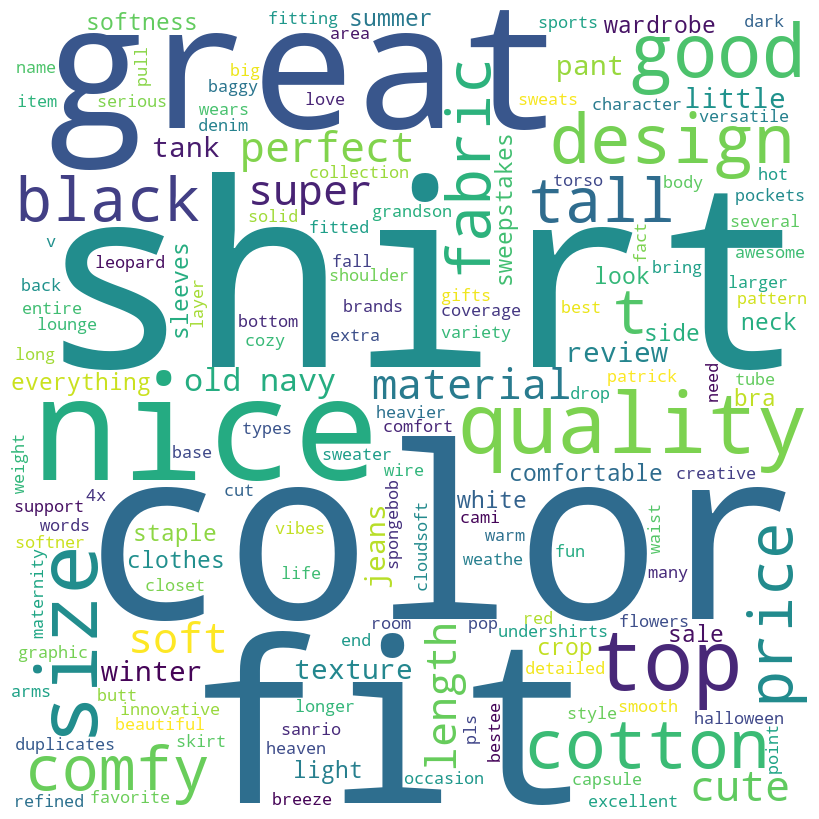

In [50]:
# Creating a Word Cloud using the Extracted Key Phrases

import matplotlib.pyplot as plt  # Use pyplot for plotting
import pandas as pd  # Ensure pandas is correctly imported
from wordcloud import WordCloud, STOPWORDS  # WordCloud and STOPWORDS for generating word clouds


# Initialize an empty string to store all words
comment_words_on = ''

# Loop through each entry in the cloud_input list
for i in range(len(cloud_input_on)):
    cloud_input_on[i] = cloud_input_on[i].lower()  # Convert to lowercase
    comment_words_on += " ".join(cloud_input_on[i].split()) + " "  # Concatenate words with spaces

# Define stopwords
stopwords = set(STOPWORDS)

# Generate word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words_on)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)